In [11]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib as mpl
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [4]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']
phastcons = od+config['ref']['phastcons100']['txt']


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
m_cerb_gtf = od+expand(config['lr']['cerberus']['gtf'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

## TES phastcons

In [15]:
ca = cerberus.read(cerberus_h5)
df = ca.tes.copy(deep=True)
df['tes_len'] = (df.End-df.Start).abs()
assert len(df.Name.unique()) == len(df.index)
df = df[['Chromosome', 'Start', 'End', 'Name']]
df.to_csv('tes_for_cons.bed', sep='\t', index=False, header=None)

## TSS phastcons

In [16]:
ca = cerberus.read(cerberus_h5)
df = ca.tss.copy(deep=True)
df['tss_len'] = (df.End-df.Start).abs()
assert len(df.Name.unique()) == len(df.index)
df = df[['Chromosome', 'Start', 'End', 'Name']]
df.to_csv('tss_for_cons.bed', sep='\t', index=False, header=None)

## Splice flank scores

In [6]:
def read_cons_table():
    df = pd.read_csv(human_mouse_sect_cons, sep='\t')
    print(len(df.index))
    df['sector_conserved'] = df.sector_human == df.sector_mouse
    df['splicing_conserved']  = (df.sector_human=='splicing')&(df.sector_mouse=='splicing')
    gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist()
    return df

13494
Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 191325
191325
162454
im here
1822386
754753
754753
181166
1462694
1461602


,Chromosome,Start,End,Strand,gene_id,Name,region_len
0,chr1,169795213,169795263,+,ENSG00000000460,ENSG00000000460_10,50
1,chr1,169798868,169798918,+,ENSG00000000460,ENSG00000000460_10,50
2,chr1,169798958,169799008,+,ENSG00000000460,ENSG00000000460_10,50
3,chr1,169800832,169800882,+,ENSG00000000460,ENSG00000000460_10,50
4,chr1,169800971,169801021,+,ENSG00000000460,ENSG00000000460_10,50


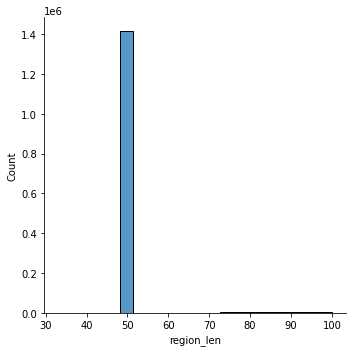

In [37]:
df = read_cons_table()

h_ca = cerberus.read(cerberus_h5)
h_ic = h_ca.ic.loc[h_ca.ic.gene_id.isin(df.gid_human.tolist())]
sj_df, sj_ic_df = get_sj_from_ic(h_ic, ['v29', 'v40'])

# get ids from detected ics from detected transcripts from mouse and human
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, _ = get_tpm_table(h_ab,
               how='iso',
               min_tpm=min_tpm,
               gene_subset='protein_coding', 
               groupby=obs_col)

# limit to mouse match samples
temp = temp[get_mouse_match_samples()]
print(len(temp.index))
temp = temp.loc[temp.any(axis=1)>=min_tpm]
print(len(temp.index))
tids = temp.index.tolist()

temp = pd.DataFrame()
temp['tid'] = tids
temp['ic'] = temp.tid.str.split('[', expand=True)[0]+'_'+\
             temp.tid.str.split('[', expand=True)[1].str.split(',', expand=True)[1]
print('im here')
print(len(sj_ic_df.index))
sj_ic_df = sj_ic_df.loc[sj_ic_df.Name.isin(temp['ic'].tolist())]
print(len(sj_ic_df.index))

sj_ic_df['iid'] = sj_ic_df.Chromosome+'_'+\
                 sj_ic_df.Strand+'_'+\
                 sj_ic_df.Start.astype(str)+'_'+\
                 sj_ic_df.End.astype(str)
sj_ic_df.head()
print(len(sj_ic_df.index))
print(len(sj_ic_df.iid.unique().tolist()))

# convert to PyRanges and get 50 nt upstream and downstream of each sj coordiate
extend = 50
len_min = extend*2
cols = ['Chromosome', 'Strand', 'Start', 'End', 'gene_id', 'Name']
h_df = sj_ic_df[cols].drop_duplicates()

n = len(h_df.index)
temp_h_df = h_df.loc[(h_df.End-h_df.Start)<len_min]
h_df = h_df.loc[~((h_df.End-h_df.Start)<len_min)]
assert len(temp_h_df.index)+len(h_df.index) == n

# introns >= 2*extension length
h_df['flank_5_End'] = h_df.Start+50
h_df['flank_3_Start'] = h_df.End-50
h_df.rename({'Start':'flank_5_Start',
             'End':'flank_3_End'},
            axis=1, inplace=True)
h_df['flank_5'] = h_df['flank_5_Start'].astype(str)+'_'+h_df['flank_5_End'].astype(str)
h_df['flank_3'] = h_df['flank_3_Start'].astype(str)+'_'+h_df['flank_3_End'].astype(str)
h_df.drop(['flank_5_Start', 'flank_5_End', 'flank_3_Start', 'flank_3_End'], axis=1, inplace=True)
h_df = h_df.melt(id_vars=['Chromosome', 'gene_id', 'Name', 'Strand'])
h_df[['Start', 'End']] = h_df.value.str.split('_', expand=True)
h_df['Start'] = h_df['Start'].astype(int)
h_df['End'] = h_df['End'].astype(int)

h_df.drop(['value', 'variable'], axis=1, inplace=True)
# print(h_df.loc[h_df.Name=='ENSG00000122435_1'])


# introns < 2*exension length just get the whole intron
h_df = pd.concat([h_df, temp_h_df], axis=0)

print(len(h_df.index))
h_df = pr.PyRanges(h_df)
h_df = h_df.merge(strand=True,
                  by=['gene_id', 'Name'],
                  count=True)
h_df = h_df.df
print(len(h_df.index))

h_df['region_len'] = h_df.End-h_df.Start
sns.displot(h_df, x='region_len')

h_df_back = h_df.copy(deep=True)
assert len(h_df.loc[(h_df.Count>1)&(h_df.region_len!=100)].index) == 0
h_df.drop('Count', axis=1, inplace=True)
h_df.head()



In [38]:
h_df.head()

,Chromosome,Start,End,Strand,gene_id,Name,region_len
0,chr1,169795213,169795263,+,ENSG00000000460,ENSG00000000460_10,50
1,chr1,169798868,169798918,+,ENSG00000000460,ENSG00000000460_10,50
2,chr1,169798958,169799008,+,ENSG00000000460,ENSG00000000460_10,50
3,chr1,169800832,169800882,+,ENSG00000000460,ENSG00000000460_10,50
4,chr1,169800971,169801021,+,ENSG00000000460,ENSG00000000460_10,50


In [39]:
h_df = h_df[['Chromosome', 'Start', 'End', 'Name']]
h_df['Name'] = h_df['Name'] + '_' + [str(i) for i in range(len(h_df.index))]
h_df.to_csv('splice_flank_for_cons.bed', sep='\t', index=False, header=None)

In [40]:
h_df.head()

,Chromosome,Start,End,Name
0,chr1,169795213,169795263,ENSG00000000460_10_0
1,chr1,169798868,169798918,ENSG00000000460_10_1
2,chr1,169798958,169799008,ENSG00000000460_10_2
3,chr1,169800832,169800882,ENSG00000000460_10_3
4,chr1,169800971,169801021,ENSG00000000460_10_4


## Run bigwigavgoverbed

In [20]:
# !bigwigaverageoverbed ../../proc_revisions/ref/hg38.phastCons100way.bw tes_for_cons.bed tes_avg_gc.tab
# !bigwigaverageoverbed ../../proc_revisions/ref/hg38.phastCons100way.bw tss_for_cons.bed tss_avg_gc.tab
# !bigwigaverageoverbed ../../proc_revisions/ref/hg38.phastCons100way.bw splice_flank_for_cons.bed splice_flank_avg_gc.tab

   name - name field from bed, which should be unique
   
   size - size of bed (sum of exon sizes
   
   covered - # bases within exons covered by bigWig
   
   sum - sum of values over all bases covered
   
   mean0 - average over bases with non-covered bases counting as zeroes

   mean - average over just covered bases

I want to use mean0 because regions of transcript that aren't covered shouldn't be considered conserved.

## Avg and max TSS conservation per gene vs. delta tss

Calculating tss TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 73812
# tsss >= 1 tpm: 64913
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of tsss reported: 50292
156184
50292
                   Name  size  covered     sum     mean0      mean  \
2854  ENSG00000000460_1   140      140  37.824  0.270171  0.270171   
2994  ENSG00000000460_2   101      101   0.258  0.002554  0.002554   
7345  ENSG00000000460_3   101      101   0.730  0.007228  0.007228   

                  gid  
2854  ENSG00000000460  
2994  ENSG00000000460  
7345  ENSG00000000460  
13494
13494
Corr. between mean tss cons score and delta # tss, pearson r=-0.058834520397115245 and pval=7.934474423358227e-12
Corr. between mean tss cons score and delta # tss, spearman rho=-0.05209026095584429 and pval=1.4081414084215358e-09

Corr. between max tss cons score and delta # tss, pearson r=0.12416882206063583 and pval=1.6535608228092898e-47
Corr. between max tss cons score and delta # tss, spearman rho=

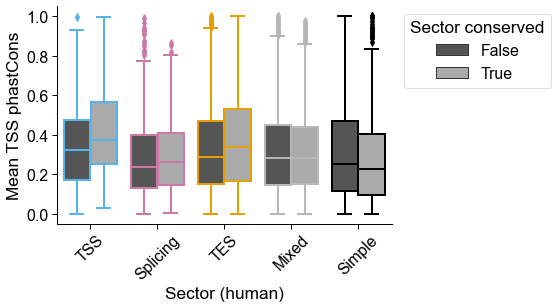

tes sector conserved vs. non conserved mean_feat_score stat: 1543819.0, pval: 8.059775449876396e-07
simple sector conserved vs. non conserved mean_feat_score stat: 326429.0, pval: 0.01866087949252567
mixed sector conserved vs. non conserved mean_feat_score stat: 4025164.5, pval: 0.6915360869983069
splicing sector conserved vs. non conserved mean_feat_score stat: 132606.0, pval: 0.15964206253924051
tss sector conserved vs. non conserved mean_feat_score stat: 291719.0, pval: 2.0184161224417103e-08



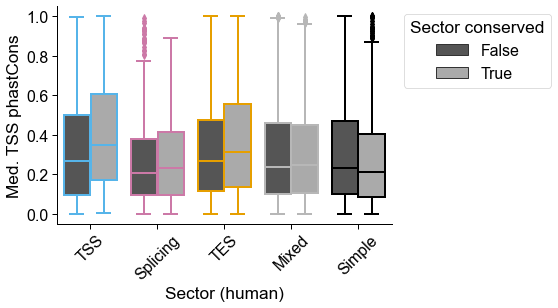

tes sector conserved vs. non conserved med_feat_score stat: 1534590.5, pval: 4.128243312752146e-06
simple sector conserved vs. non conserved med_feat_score stat: 328983.0, pval: 0.035849690464697076
mixed sector conserved vs. non conserved med_feat_score stat: 4005639.5, pval: 0.9370071277383566
splicing sector conserved vs. non conserved med_feat_score stat: 131110.5, pval: 0.2705241506149255
tss sector conserved vs. non conserved med_feat_score stat: 292053.5, pval: 1.587540551009743e-08



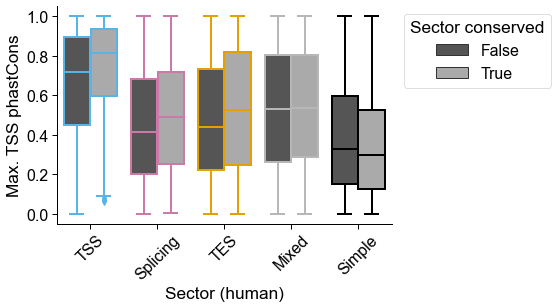

tes sector conserved vs. non conserved max_feat_score stat: 1531647.5, pval: 6.799505568162359e-06
simple sector conserved vs. non conserved max_feat_score stat: 319998.0, pval: 0.002782231457787809
mixed sector conserved vs. non conserved max_feat_score stat: 4066519.0, pval: 0.2847308788698709
splicing sector conserved vs. non conserved max_feat_score stat: 137333.5, pval: 0.01785583737854407
tss sector conserved vs. non conserved max_feat_score stat: 293565.0, pval: 5.253415170248893e-09


In [29]:
feat = 'tss'

df = pd.read_csv(f'{feat}_avg_gc.tab', sep='\t', header=None,
                 names=['Name', 'size', 'covered', 'sum', 'mean0', 'mean'])
df['gid'] = df.Name.str.split('_', expand=True)[0]

# df.loc[(df['size']!=df.covered)&(df.covered!=0)].head()
# get only the protein coding expressed ends from mouse match samples
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, ids = get_tpm_table(h_ab,
               how=feat,
               min_tpm=1,
               gene_subset='protein_coding', 
               groupby=obs_col)
print(len(df.index))
df = df.loc[df.Name.isin(ids)]
print(len(df.index))
print(df.loc[df.gid=='ENSG00000000460'])
df = df[['mean0', 'gid']]


# get sector conservation information
df2 = read_cons_table()
df2['delta_feat'] = df2[f'n_{feat}_human']-df2[f'n_{feat}_mouse']
df2.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
df2 = df2[['gid', f'n_{feat}_human',
          f'n_{feat}_mouse', 'delta_feat', 
          'sector_human', 'sector_mouse', 'sector_conserved']]

# compute mean score
temp = df.groupby('gid').mean().reset_index().rename({'mean0':'mean_feat_score'}, axis=1)

# also compute max score
temp2 = df.groupby('gid').max().reset_index().rename({'mean0':'max_feat_score'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# also compute median score
temp2 = df.groupby('gid').median().reset_index().rename({'mean0':'med_feat_score'}, axis=1)
df = temp.merge(temp2, how='left', on='gid')

# merge with sector cons. information 
df = df.merge(df2, how='inner', on='gid')
print(len(df.index))

x = df['mean_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='mean_feat_score',
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['max_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='max_feat_score', 
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['med_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='med_feat_score', 
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

c_dict, order = get_sector_colors()
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6,4))

shade_dict, _ = get_shade_colors('#000000', ['dummy', False, True])

cols = ['mean_feat_score', 'med_feat_score', 'max_feat_score']
for col in cols:
    print()
    # ax = sns.boxplot(df, y='log_mean_intron_len', x='sect_disp', order=order, palette=c_dict, fill=False)
    ax = sns.boxplot(df, x='sector_human',
                     hue='sector_conserved',
                     y=col, order=order,
                     linewidth=2,
                     palette=shade_dict)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if feat in ['tss', 'tes']:
        feat_label = feat.upper()
    else:
        feat_label = 'EC'
    col_label = col.split('_')[0].capitalize()
    if col_label != 'Mean':
        col_label+='.'
    title = f'Sector conservation vs. {feat_label} sequence conservation'
    ylabel = f'{col_label} {feat_label} phastCons'
    xlabel = 'Sector (human)'
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    # _ = ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.tick_params(axis="x", rotation=45)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i,l in enumerate(labels):
        if l in ['tss', 'tes']:
            labels[i] = l.upper()
        else:
            labels[i] = l.capitalize()
    ax.set_xticklabels(labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1),
               title='Sector conserved')
    
    box_patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax.artists
        box_patches = ax.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        
        j = int(i/2)
        sect_color = c_dict[order[j]]
        
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        # col = patch.get_facecolor()
        patch.set_edgecolor(sect_color)
        # patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(sect_color)
            line.set_mfc(sect_color)  # facecolor of fliers
            line.set_mec(sect_color)  # edgecolor of fliers

    plt.show()

    for sector in df.sector_human.unique().tolist():
        # sns.boxplot(df, x=col, kind='kde',
        #             hue='sector_conserved',
        #             linewidth=1, common_norm=False)
        temp = df.loc[df.sector_human==sector]
        x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
        y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
        stat, pval = st.mannwhitneyu(x,y)
        print(f'{sector} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')


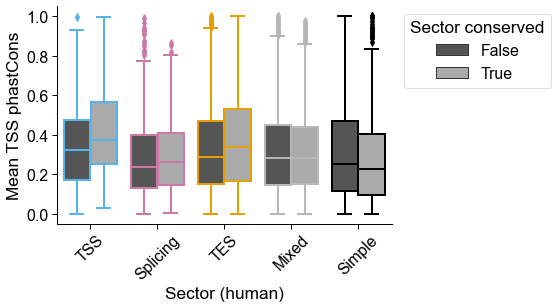

tes sector conserved vs. non conserved mean_feat_score stat: 1543819.0, pval: 8.059775449876396e-07
simple sector conserved vs. non conserved mean_feat_score stat: 326429.0, pval: 0.01866087949252567
mixed sector conserved vs. non conserved mean_feat_score stat: 4025164.5, pval: 0.6915360869983069
splicing sector conserved vs. non conserved mean_feat_score stat: 132606.0, pval: 0.15964206253924051
tss sector conserved vs. non conserved mean_feat_score stat: 291719.0, pval: 2.0184161224417103e-08



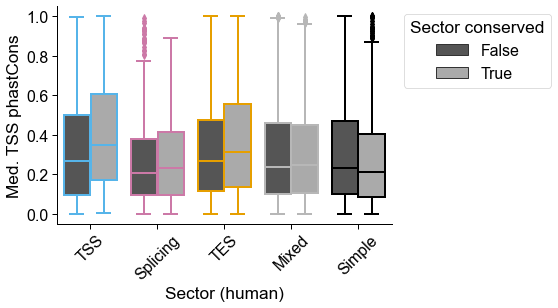

tes sector conserved vs. non conserved med_feat_score stat: 1534590.5, pval: 4.128243312752146e-06
simple sector conserved vs. non conserved med_feat_score stat: 328983.0, pval: 0.035849690464697076
mixed sector conserved vs. non conserved med_feat_score stat: 4005639.5, pval: 0.9370071277383566
splicing sector conserved vs. non conserved med_feat_score stat: 131110.5, pval: 0.2705241506149255
tss sector conserved vs. non conserved med_feat_score stat: 292053.5, pval: 1.587540551009743e-08



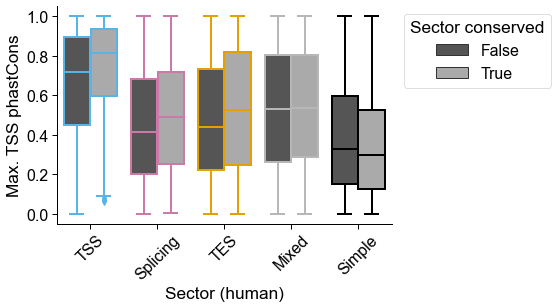

tes sector conserved vs. non conserved max_feat_score stat: 1531647.5, pval: 6.799505568162359e-06
simple sector conserved vs. non conserved max_feat_score stat: 319998.0, pval: 0.002782231457787809
mixed sector conserved vs. non conserved max_feat_score stat: 4066519.0, pval: 0.2847308788698709
splicing sector conserved vs. non conserved max_feat_score stat: 137333.5, pval: 0.01785583737854407
tss sector conserved vs. non conserved max_feat_score stat: 293565.0, pval: 5.253415170248893e-09


In [28]:
c_dict, order = get_sector_colors()
sns.set_context('paper', font_scale=1.8)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(6,4))

shade_dict, _ = get_shade_colors('#000000', ['dummy', False, True])

cols = ['mean_feat_score', 'med_feat_score', 'max_feat_score']
for col in cols:
    print()
    # ax = sns.boxplot(df, y='log_mean_intron_len', x='sect_disp', order=order, palette=c_dict, fill=False)
    ax = sns.boxplot(df, x='sector_human',
                     hue='sector_conserved',
                     y=col, order=order,
                     linewidth=2,
                     palette=shade_dict)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if feat in ['tss', 'tes']:
        feat_label = feat.upper()
    else:
        feat_label = 'EC'
    col_label = col.split('_')[0].capitalize()
    if col_label != 'Mean':
        col_label+='.'
    title = f'Sector conservation vs. {feat_label} sequence conservation'
    ylabel = f'{col_label} {feat_label} phastCons'
    xlabel = 'Sector (human)'
    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    # _ = ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.tick_params(axis="x", rotation=45)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i,l in enumerate(labels):
        if l in ['tss', 'tes']:
            labels[i] = l.upper()
        else:
            labels[i] = l.capitalize()
    ax.set_xticklabels(labels)
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1),
               title='Sector conserved')
    
    box_patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax.artists
        box_patches = ax.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        
        j = int(i/2)
        sect_color = c_dict[order[j]]
        
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        # col = patch.get_facecolor()
        patch.set_edgecolor(sect_color)
        # patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(sect_color)
            line.set_mfc(sect_color)  # facecolor of fliers
            line.set_mec(sect_color)  # edgecolor of fliers

    plt.show()

    for sector in df.sector_human.unique().tolist():
        # sns.boxplot(df, x=col, kind='kde',
        #             hue='sector_conserved',
        #             linewidth=1, common_norm=False)
        temp = df.loc[df.sector_human==sector]
        x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
        y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
        stat, pval = st.mannwhitneyu(x,y)
        print(f'{sector} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')

## Avg and max TES conservation per gene vs. delta from cerberus

Calculating tes TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 87189
# tess >= 1 tpm: 76035
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of tess reported: 59903
187005
59903
                   Name  size  covered     sum     mean0      mean  \
2     ENSG00000000460_6   101      101  54.541  0.540010  0.540010   
1546  ENSG00000000460_1   101      101   1.032  0.010218  0.010218   
4077  ENSG00000000460_2   140      140  15.748  0.112486  0.112486   
9552  ENSG00000000460_3   149      149  63.887  0.428772  0.428772   

                  gid  
2     ENSG00000000460  
1546  ENSG00000000460  
4077  ENSG00000000460  
9552  ENSG00000000460  
13494
13494
Corr. between mean tes cons score and delta # tes, pearson r=-0.09602552466876456 and pval=5.138685913405751e-29
Corr. between mean tes cons score and delta # tes, spearman rho=-0.07896722066406103 and pval=4.053760141858129e-20

Corr. between max tes cons score and delta # tes, pearson r=0.0763137069558148 and 

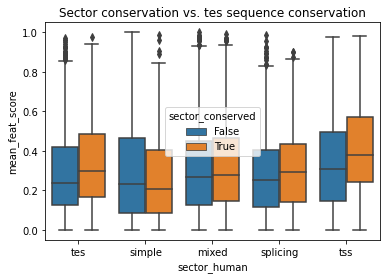

tes sector conserved vs. non conserved mean_feat_score stat: 1594277.0, pval: 1.658751667406554e-11
simple sector conserved vs. non conserved mean_feat_score stat: 332414.0, pval: 0.07875867765312687
mixed sector conserved vs. non conserved mean_feat_score stat: 4124124.5, pval: 0.04472913368101052
splicing sector conserved vs. non conserved mean_feat_score stat: 136773.0, pval: 0.024164720504173582
tss sector conserved vs. non conserved mean_feat_score stat: 290516.0, pval: 4.721481044541318e-08



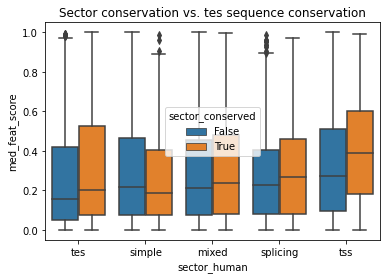

tes sector conserved vs. non conserved med_feat_score stat: 1571700.0, pval: 3.063258537071996e-09
simple sector conserved vs. non conserved med_feat_score stat: 333158.0, pval: 0.09217081906924494
mixed sector conserved vs. non conserved med_feat_score stat: 4113869.0, pval: 0.06572414918800716
splicing sector conserved vs. non conserved med_feat_score stat: 134380.0, pval: 0.07716339363515506
tss sector conserved vs. non conserved med_feat_score stat: 288692.0, pval: 1.6436570735580559e-07



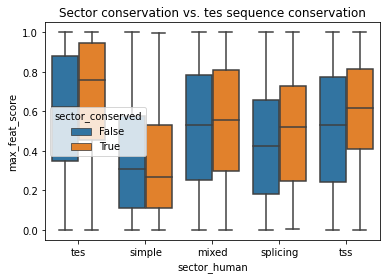

tes sector conserved vs. non conserved max_feat_score stat: 1642490.5, pval: 2.8482382910588135e-17
simple sector conserved vs. non conserved max_feat_score stat: 329767.5, pval: 0.043307892351160754
mixed sector conserved vs. non conserved max_feat_score stat: 4140225.5, pval: 0.02325543542853107
splicing sector conserved vs. non conserved max_feat_score stat: 141641.0, pval: 0.0011727845296095548
tss sector conserved vs. non conserved max_feat_score stat: 285779.5, pval: 1.0872625164625837e-06


In [69]:
feat = 'tes'

df = pd.read_csv(f'{feat}_avg_gc.tab', sep='\t', header=None,
                 names=['Name', 'size', 'covered', 'sum', 'mean0', 'mean'])
df['gid'] = df.Name.str.split('_', expand=True)[0]

# df.loc[(df['size']!=df.covered)&(df.covered!=0)].head()
# get only the protein coding expressed ends from mouse match samples
h_ab = pd.read_csv(filt_ab, sep='\t')
temp, ids = get_tpm_table(h_ab,
               how=feat,
               min_tpm=1,
               gene_subset='protein_coding', 
               groupby=obs_col)
print(len(df.index))
df = df.loc[df.Name.isin(ids)]
print(len(df.index))
print(df.loc[df.gid=='ENSG00000000460'])
df = df[['mean0', 'gid']]


# get sector conservation information
df2 = read_cons_table()
df2['delta_feat'] = df2[f'n_{feat}_human']-df2[f'n_{feat}_mouse']
df2.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
df2 = df2[['gid', f'n_{feat}_human',
          f'n_{feat}_mouse', 'delta_feat', 
          'sector_human', 'sector_mouse', 'sector_conserved']]

# compute mean score
temp = df.groupby('gid').mean().reset_index().rename({'mean0':'mean_feat_score'}, axis=1)

# also compute max score
temp2 = df.groupby('gid').max().reset_index().rename({'mean0':'max_feat_score'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# also compute median score
temp2 = df.groupby('gid').median().reset_index().rename({'mean0':'med_feat_score'}, axis=1)
df = temp.merge(temp2, how='left', on='gid')

# merge with sector cons. information 
df = df.merge(df2, how='inner', on='gid')
print(len(df.index))

x = df['mean_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between mean {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='mean_feat_score',
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['max_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between max {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='max_feat_score', 
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

x = df['med_feat_score'].tolist()
y = df['delta_feat'].tolist()
r, pval = stats.pearsonr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, pearson r={r} and pval={pval}')
rho, pval = stats.spearmanr(x,y)
print(f'Corr. between med {feat} cons score and delta # {feat}, spearman rho={rho} and pval={pval}')
# sns.jointplot(df, x='delta_feat',
#               y='med_feat_score', 
#               joint_kws={'s':4, 'alpha':0.25})
plt.show()
print()

cols = ['mean_feat_score', 'med_feat_score', 'max_feat_score']
for col in cols:
    print()
    ax = sns.boxplot(df, x='sector_human', hue='sector_conserved', y=col)
    ax.set(title=f'Sector conservation vs. {feat} sequence conservation') 
    plt.show()

    for sector in df.sector_human.unique().tolist():
        # sns.boxplot(df, x=col, kind='kde',
        #             hue='sector_conserved',
        #             linewidth=1, common_norm=False)
        temp = df.loc[df.sector_human==sector]
        x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
        y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
        stat, pval = st.mannwhitneyu(x,y)
        print(f'{sector} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')

## Splice flank conservation vs. delta splicing number

13494
13185
Corr. between splice flank cons score and delta splicing ratio, pearson r=-0.03270733641792402 and pval=0.00017244396697767915

Corr. between splice flank cons score and delta splicing ratio, spearman rho=-0.03867937626089539 and pval=8.886275484155191e-06



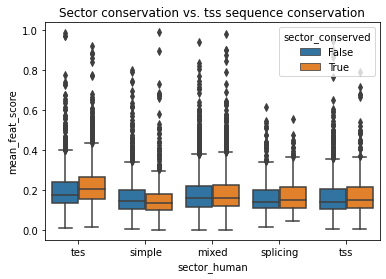

tes sector conserved vs. non conserved mean_feat_score stat: 1608780.5, pval: 2.920200576040168e-17
simple sector conserved vs. non conserved mean_feat_score stat: 265712.0, pval: 0.006311500535258889
mixed sector conserved vs. non conserved mean_feat_score stat: 4025613.0, pval: 0.2609933473252629
splicing sector conserved vs. non conserved mean_feat_score stat: 132026.0, pval: 0.19767178954956766
tss sector conserved vs. non conserved mean_feat_score stat: 228559.0, pval: 0.022703939787107125



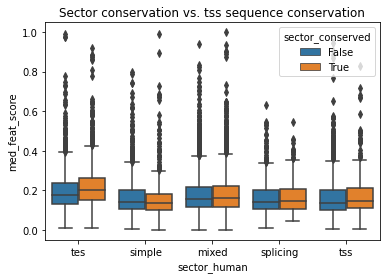

tes sector conserved vs. non conserved med_feat_score stat: 1607771.0, pval: 3.992178109884988e-17
simple sector conserved vs. non conserved med_feat_score stat: 266085.5, pval: 0.007176243969514237
mixed sector conserved vs. non conserved med_feat_score stat: 4008803.0, pval: 0.3963245016864415
splicing sector conserved vs. non conserved med_feat_score stat: 131782.5, pval: 0.2154762990418425
tss sector conserved vs. non conserved med_feat_score stat: 227192.0, pval: 0.03660226233961822



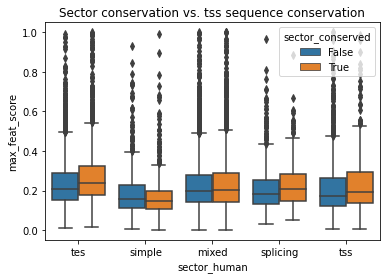

tes sector conserved vs. non conserved max_feat_score stat: 1577436.0, pval: 2.597317745101526e-13
simple sector conserved vs. non conserved max_feat_score stat: 264630.5, pval: 0.004310906560455491
mixed sector conserved vs. non conserved max_feat_score stat: 4054886.0, pval: 0.10862595112890647
splicing sector conserved vs. non conserved max_feat_score stat: 140331.0, pval: 0.002894197701952064
tss sector conserved vs. non conserved max_feat_score stat: 229601.0, pval: 0.015442080085736946


In [71]:
df = pd.read_csv('splice_flank_avg_gc.tab', sep='\t', header=None,
                 names=['Name', 'size', 'covered', 'sum', 'mean0', 'mean'])
df['gid'] = df.Name.str.split('_', expand=True)[0]
df['ic'] = df.Name.str.rsplit('_', n=1, expand=True)[0]
df.drop('Name', axis=1, inplace=True)
df.head()
df = df.groupby(['gid', 'ic']).agg({'size': 'sum',
                                    'covered': 'sum',
                                    'sum': 'sum',
                                    'mean0': 'mean',
                                    'mean': 'mean'}).reset_index()

df2 = read_cons_table()
df2['delta_spl_ratio'] = df2.splicing_ratio_human-df2.splicing_ratio_mouse
df2.rename({'Gene stable ID': 'gid'}, axis=1, inplace=True)
df2 = df2[['gid', 'splicing_ratio_human',
           'splicing_ratio_mouse', 'delta_spl_ratio',
           'sector_human', 'sector_mouse', 'sector_conserved']]

# compute mean score
temp = df.groupby('gid').mean().reset_index().rename({'mean0':'mean_feat_score'}, axis=1)

# also compute max score
temp2 = df.groupby('gid').max().reset_index().rename({'mean0':'max_feat_score'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# also compute median score
temp2 = df.groupby('gid').median().reset_index().rename({'mean0':'med_feat_score'}, axis=1)
df = temp.merge(temp2, how='left', on='gid')

# merge with sector cons. information 
df = df.merge(df2, how='inner', on='gid')
print(len(df.index))

x = df.mean_feat_score.tolist()
y = df.delta_spl_ratio.tolist()

r, pval = stats.pearsonr(x,y)
print(f'Corr. between splice flank cons score and delta splicing ratio, pearson r={r} and pval={pval}')

print()

rho, pval = stats.spearmanr(x,y)
print(f'Corr. between splice flank cons score and delta splicing ratio, spearman rho={rho} and pval={pval}')

# sns.jointplot(df, x='delta_spl_ratio',
#               y='mean_feat_score')

cols = ['mean_feat_score', 'med_feat_score', 'max_feat_score']
for col in cols:
    print()
    ax = sns.boxplot(df, x='sector_human', hue='sector_conserved', y=col)
    ax.set(title=f'Sector conservation vs. {feat} sequence conservation') 
    plt.show()

    for sector in df.sector_human.unique().tolist():
        # sns.boxplot(df, x=col, kind='kde',
        #             hue='sector_conserved',
        #             linewidth=1, common_norm=False)
        temp = df.loc[df.sector_human==sector]
        x = temp.loc[temp.sector_conserved==True, col].dropna().tolist()
        y = temp.loc[temp.sector_conserved==False, col].dropna().tolist()
        stat, pval = st.mannwhitneyu(x,y)
        print(f'{sector} sector conserved vs. non conserved {col} stat: {stat}, pval: {pval}')